<h1 style="color:darkblue; text-align:center;">DL Models Optimization: Pruning, Quantization</h1>

Pruning et Quantization sont deux méthodes d'optimisation de modèles de deep learning, utilisées pour
Réduire la taille du modèle ,Accélérer l’inférence ... ,Dans ce tutoriel, nous allons :

1)Entraîner un modèle de reconnaissance de chiffres manuscrits sur le dataset MNIST

2)Appliquer deux techniques d’optimisation :

 3)Comparer les tailles et performances des modèles optimisés


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot

2025-05-09 22:59:28.908275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [6]:
len(X_train)

60000

In [8]:
len(X_test)

10000

In [10]:
X_train[0].shape

(28, 28)

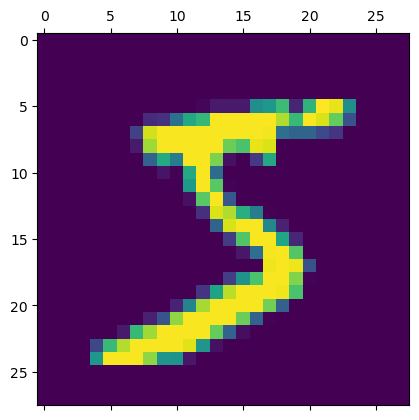

In [12]:
plt.matshow(X_train[0])

In [14]:
y_train[0]

5

In [16]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # Correction: changé sigmoid en softmax pour classification multinomiale
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 17s 2ms/step - loss: 0.2734 - accuracy: 0.9226
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1233 - accuracy: 0.9637
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0866 - accuracy: 0.9742
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0668 - accuracy: 0.9795
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0522 - accuracy: 0.9840


In [20]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0792 - accuracy: 0.9747


[0.07916077971458435, 0.9746999740600586]

<h3 style='color:blue'>(1) Pruning (taille réduite du modèle)</h3>

In [75]:

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=np.ceil(X_train.shape[0] / 32).astype(np.int32) * 3
    )
}

pruned_model = prune_low_magnitude(model, **pruning_params)

pruned_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

pruned_model.fit(X_train, y_train,
          batch_size=32, epochs=3,
          validation_split=0.1,
          callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/3
1688/1688 [==============================] - 7s 3ms/step - loss: 0.0424 - accuracy: 0.9872 - val_loss: 0.0337 - val_accuracy: 0.9895
Epoch 2/3
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0329 - accuracy: 0.9907 - val_loss: 0.0363 - val_accuracy: 0.9877
Epoch 3/3
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0253 - accuracy: 0.9929 - val_loss: 0.0355 - val_accuracy: 0.9882


In [83]:
pruned_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9790


[0.06884318590164185, 0.9789999723434448]

In [85]:
pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 100)               156902    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2012      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 158915 (620.77 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 79405 (310.19 KB)
_________________________________________________________________


<h3 style='color:blue'>(2) Quantification post-formation</h3>

**Sans quantification**

In [89]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmp1lvb88h_/assets


INFO:tensorflow:Assets written to: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmp1lvb88h_/assets
W0000 00:00:1746831642.227472  782987 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1746831642.227489  782987 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-05-10 00:00:42.227711: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmp1lvb88h_
2025-05-10 00:00:42.228577: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-05-10 00:00:42.228592: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmp1lvb88h_
2025-05-10 00:00:42.236673: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-05-10 00:00:42.265621: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /var/folders/27/pfjs1z69

**Avec quantification**

In [92]:
# Convertir en TFLite avec quantification
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpj020c4r6/assets


INFO:tensorflow:Assets written to: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpj020c4r6/assets
W0000 00:00:1746831644.916441  782987 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1746831644.916455  782987 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-05-10 00:00:44.916640: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpj020c4r6
2025-05-10 00:00:44.917439: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-05-10 00:00:44.917450: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpj020c4r6
2025-05-10 00:00:44.924925: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-05-10 00:00:44.953496: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /var/folders/27/pfjs1z69

In [94]:
len(tflite_model)

319936

In [96]:
len(tflite_quant_model)

84816

In [98]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [100]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

<h3 style='color:blue'>(3) Quantization aware training</h3>

In [103]:
quantize_model = tfmot.quantization.keras.quantize_model

# Créer un modèle avec awareness de quantification
q_aware_model = quantize_model(model)

# Recompiler le modèle
q_aware_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Afficher le résumé du modèle avec quantification
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (Quantize  (None, 28, 28)            3         
 Layer)                                                          
                                                                 
 quant_flatten (QuantizeWra  (None, 784)               1         
 pperV2)                                                         
                                                                 
 quant_dense (QuantizeWrapp  (None, 100)               78505     
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                1015      
 pperV2)                                                         
                                                                 
Total params: 79524 (310.64 KB)
Trainable params: 79510 

In [105]:
# Entraîner le modèle conscient de la quantification
q_aware_model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0820 - val_accuracy: 0.9758


In [106]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0820 - accuracy: 0.9758


[0.08204996585845947, 0.9757999777793884]

In [107]:
# Convertir le modèle conscient de la quantification en TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpiqgkx_vq/assets


INFO:tensorflow:Assets written to: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpiqgkx_vq/assets
/opt/anaconda3/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1746831658.973414  782987 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1746831658.973427  782987 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-05-10 00:00:58.973647: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpiqgkx_vq
2025-05-10 00:00:58.975852: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-05-10 00:00:58.975877: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/27/pfjs1z692ml4r915h67q79x40000gn/T/tmpiqgkx_vq
2025-05-10 00:00:58.991683: I tensorflow/cc/saved_mod

In [108]:
len(tflite_qaware_model)

82712

In [113]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)